<a href="https://colab.research.google.com/github/chi-hun/dacon/blob/main/%EC%9C%A0%EB%B0%A9%EC%95%94%EC%9D%98_%EC%9E%84%ED%8C%8C%EC%84%A0_%EC%A0%84%EC%9D%B4_%EC%98%88%EC%B8%A1_AI%EA%B2%BD%EC%A7%84%EB%8C%80%ED%9A%8C.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

유방암의 임파선 전이 예측 AI경진대회
https://dacon.io/competitions/official/236011/overview/description

In [53]:
import os
import pandas as pd
import cv2
import matplotlib.pyplot as plt
import seaborn as sns
import shutil
import glob
import tqdm

In [ ]:
!unzip '/content/drive/MyDrive/Colab Notebooks/데이콘/유방암의 임파선 전이 예측 AI경진대회/train_1.zip'

In [48]:
train_path = sorted(glob.glob('/content/train/*.png'))

In [54]:
train_csv.head(3)

,ID,img_path,mask_path,나이,수술연월일,진단명,암의 위치,암의 개수,암의 장경,NG,...,ER_Allred_score,PR,PR_Allred_score,KI-67_LI_percent,HER2,HER2_IHC,HER2_SISH,HER2_SISH_ratio,BRCA_mutation,N_category
0,BC_01_0001,./train_imgs/BC_01_0001.png,-,63,2015-10-23,1,2,1,19.0,2.0,...,8.0,1.0,6.0,12.0,0.0,1.0,NaN,NaN,NaN,0
1,BC_01_0002,./train_imgs/BC_01_0002.png,-,51,2015-10-28,1,1,1,22.0,3.0,...,NaN,0.0,NaN,70.0,0.0,0.0,NaN,NaN,NaN,1
2,BC_01_0003,./train_imgs/BC_01_0003.png,-,37,2015-10-29,1,2,1,NaN,2.0,...,7.0,1.0,4.0,7.0,0.0,1.0,NaN,NaN,0.0,0


In [52]:
train_path[0].split('/')[-1].split('.')[0]

'BC_01_0001'

In [71]:
for i, path in tqdm.tqdm(enumerate(train_path)):
    id = path.split('/')[-1].split('.')[0]
    assert train_csv.iloc[i]['ID'] == id
    train_csv.loc[i, 'img_path'] = path

1000it [00:00, 2035.60it/s]


In [72]:
train_csv.head(3)

,ID,img_path,mask_path,나이,수술연월일,진단명,암의 위치,암의 개수,암의 장경,NG,...,ER_Allred_score,PR,PR_Allred_score,KI-67_LI_percent,HER2,HER2_IHC,HER2_SISH,HER2_SISH_ratio,BRCA_mutation,N_category
0,BC_01_0001,/content/train/BC_01_0001.png,-,63,2015-10-23,1,2,1,19.0,2.0,...,8.0,1.0,6.0,12.0,0.0,1.0,NaN,NaN,NaN,0
1,BC_01_0002,/content/train/BC_01_0002.png,-,51,2015-10-28,1,1,1,22.0,3.0,...,NaN,0.0,NaN,70.0,0.0,0.0,NaN,NaN,NaN,1
2,BC_01_0003,/content/train/BC_01_0003.png,-,37,2015-10-29,1,2,1,NaN,2.0,...,7.0,1.0,4.0,7.0,0.0,1.0,NaN,NaN,0.0,0


In [ ]:
!unzip '/content/drive/MyDrive/Colab Notebooks/데이콘/유방암의 임파선 전이 예측 AI경진대회/train_mask_1.zip'

In [75]:
train_mask_path = sorted(glob.glob('/content/train_mask/*.png'))

In [79]:
for path in train_mask_path:
    mask = path.split('/')[-1].split('.')[0]
    train_csv.loc[train_csv['ID'] == mask, 'mask_path'] = path

In [81]:
train_csv_mask = train_csv[train_csv['mask_path'] != '-']

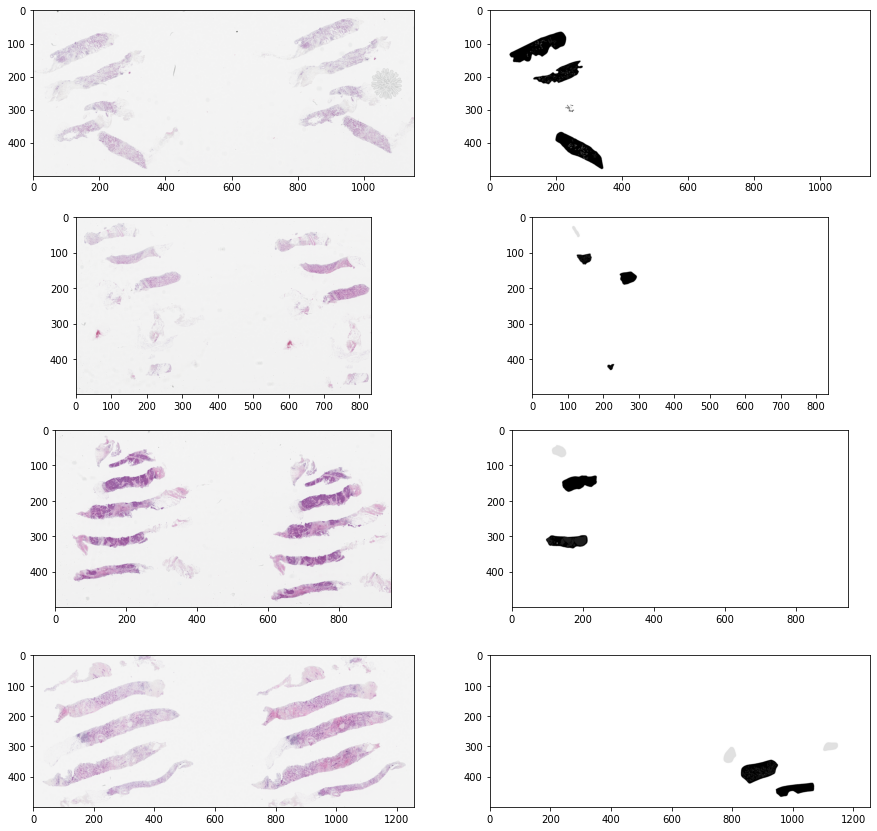

In [100]:
plt.figure(figsize=(15,15))
for i in range(4):
    plt.subplot(4,2,i*2+1)
    img = cv2.imread(train_csv_mask['img_path'].values[i])
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    plt.imshow(img)
    plt.subplot(4,2,i*2+2)
    img_m = cv2.imread(train_csv_mask['mask_path'].values[i])
    img_m = cv2.cvtColor(img_m, cv2.COLOR_BGR2RGB)
    plt.imshow(img_m)
plt.show()

In [103]:
train_csv['N_category'].value_counts()

1    514
0    486
Name: N_category, dtype: int64

In [106]:
train_csv.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 28 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   ID                 1000 non-null   object 
 1   img_path           1000 non-null   object 
 2   mask_path          1000 non-null   object 
 3   나이                 1000 non-null   int64  
 4   수술연월일              1000 non-null   object 
 5   진단명                1000 non-null   int64  
 6   암의 위치              1000 non-null   int64  
 7   암의 개수              1000 non-null   int64  
 8   암의 장경              931 non-null    float64
 9   NG                 949 non-null    float64
 10  HG                 914 non-null    float64
 11  HG_score_1         908 non-null    float64
 12  HG_score_2         908 non-null    float64
 13  HG_score_3         911 non-null    float64
 14  DCIS_or_LCIS_여부    1000 non-null   int64  
 15  DCIS_or_LCIS_type  126 non-null    float64
 16  T_category         996 no

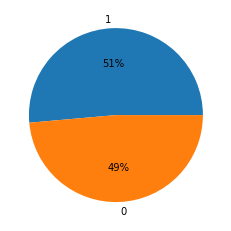

In [111]:
plt.pie(train_csv['N_category'].value_counts().values, labels=train_csv['N_category'].value_counts().index, autopct='%.0f%%')
plt.show()

/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 45208 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 51060 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:183: RuntimeWarning: Glyph 45208 missing from current font.
  font.set_text(s, 0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:183: RuntimeWarning: Glyph 51060 missing from current font.
  font.set_text(s, 0, flags=flags)


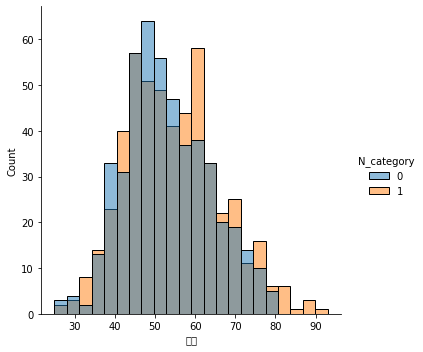

In [118]:
sns.displot(data=train_csv, x='나이', hue='N_category',)
plt.show()

/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 51652 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 45800 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 47749 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:183: RuntimeWarning: Glyph 51652 missing from current font.
  font.set_text(s, 0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:183: RuntimeWarning: Glyph 45800 missing from current font.
  font.set_text(s, 0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:183: RuntimeWarning: Glyph 47749 missing from current font.
  font.set_text

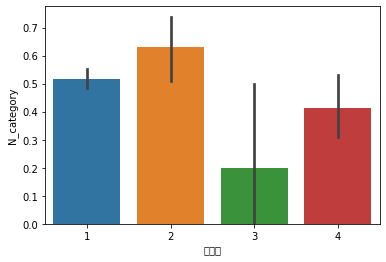

In [119]:
sns.barplot(data=train_csv, x='진단명', y='N_category')
plt.show()